In [46]:
%matplotlib inline

import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve,average_precision_score
from sklearn.metrics import mean_squared_error,r2_score
from scipy.sparse import csr_matrix, csc_matrix
import random as random
from sklearn.decomposition import NMF,TruncatedSVD
#Fit the code to the screen
from IPython.core.display import HTML
HTML("<style>.container { width:100% !important; }</style>")

### Reading the ratings data

In [18]:
#Reading the ratings data
my_path = !pwd
ratings_filename = "/ml-1m/ratings.dat"
dfratings = pd.read_csv(my_path[0]+ratings_filename, index_col=None, sep='::', header=None)
dfratings.columns = ["userId", "movieId", "rating", "timestamp"]

/tank/home/adif/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:4: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators; you can avoid this warning by specifying engine='python'.


### Creating ratings sparse matrix

In [54]:
#Split to train and test sets
test_idx = np.array(random.sample(range(0,len(dfratings)), int(len(dfratings)/10)))
train_idx = set(np.arange(len(dfratings))) - set(test_idx)
train_idx = list(train_idx)
dfratings["like"] = dfratings["rating"].apply(lambda x: 1 if x>=4 else 0)
dfratings_test = dfratings.iloc[test_idx]
dfratings_train = dfratings.iloc[train_idx]
i=0
for i1,rows in dfratings_test.iterrows():
    print rows
    i+=1
    if i>5:
        break

userId             800
movieId            208
rating               1
timestamp    975403367
like                 0
Name: 124187, dtype: int64
userId             5787
movieId            1304
rating                3
timestamp    1033847310
like                  0
Name: 959036, dtype: int64
userId             926
movieId           1610
rating               4
timestamp    975251007
like                 1
Name: 143500, dtype: int64
userId             139
movieId           1334
rating               1
timestamp    977362580
like                 0
Name: 17977, dtype: int64
userId             905
movieId           1179
rating               4
timestamp    975210902
like                 1
Name: 140877, dtype: int64
userId            2629
movieId           1270
rating               5
timestamp    973629002
like                 1
Name: 431530, dtype: int64


In [99]:
users = (dfratings_train["userId"]).unique()
movies = (dfratings_train["movieId"]).unique()
users_num = max(users)
movies_num = max(movies)
users_num += 1
movies_num += 1

In [55]:
predictions_dict = dict()
train_csr = csr_matrix((dfratings_train['like'],(dfratings_train['userId'],dfratings_train['movieId'])), shape=(users_num, movies_num), dtype=float)
nmf_components_list = [4,32,256]
for nmf_components in nmf_components_list:
    nmf = NMF(n_components=nmf_components) 
    us = nmf.fit_transform(train_csr)
    vt = nmf.components_
    pred = [np.dot(us[row['userId'],:],vt[:,row['movieId']])  for index,row in dfratings_test.iterrows()]
#    for idx in range(len(pred)):
#        if pred[idx]<1:
#            pred[idx]=1
#        if pred[idx]>5:    
#            pred[idx]=5
    predictions_dict["NMF{0}".format(nmf_components)] = pred

svd_components_list = [4,32,256]
for svd_components in svd_components_list:
    svd = TruncatedSVD(n_components=svd_components, random_state=42) 
    us = svd.fit_transform(train_csr)
    vt = svd.components_
    pred = [np.dot(us[row['userId'],:],vt[:,row['movieId']])  for index,row in dfratings_test.iterrows()]
#    for idx in range(len(pred)):
#        if pred[idx]<1:
#            pred[idx]=1
#        if pred[idx]>5:    
#            pred[idx]=5
    predictions_dict["SVD{0}".format(svd_components)] = pred


In [56]:
label = dfratings_test['like'] # the real ratings
for predictor in predictions_dict.keys():
    print predictor, mean_squared_error(predictions_dict[predictor],label)


SVD4 0.382239611141
NMF8 0.36918402584
SVD8 0.360192573939
NMF4 0.386324431781
NMF16 0.354201330476
SVD16 0.345642577272
SVD32 0.341492505389
NMF32 0.352897697062


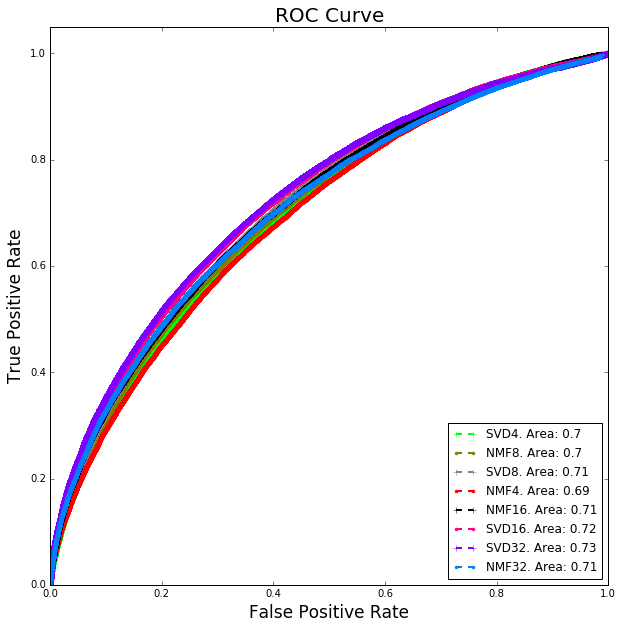

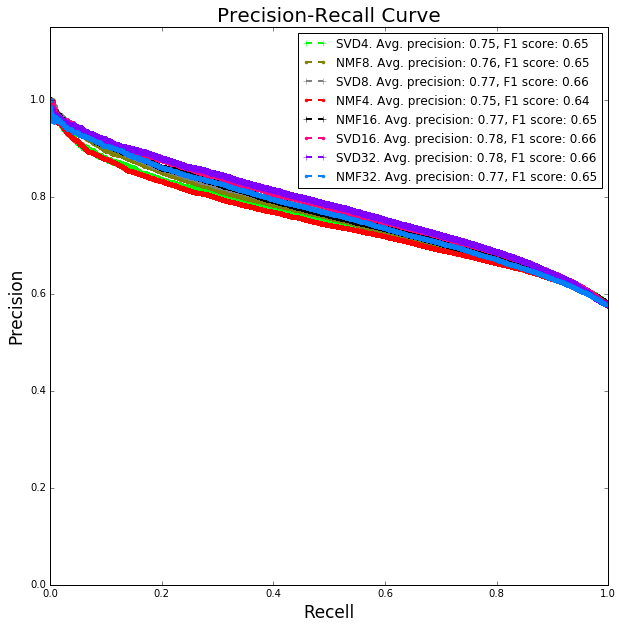

In [59]:
markers = ['+','.']
colors = ["#00ff00","#808000","#808080","#ff0000","#000000","#ff0080","#8000ff","#0080ff","#000080","#00ffff"]

def plot_roc_curve(predictions_dict,label):
    plt.clf()
    fig,ax = plt.subplots()        
    plt.xlabel('False Positive Rate',fontsize=17)
    plt.ylabel('True Positive Rate',fontsize=17)
    ax.set_title("ROC Curve",fontsize=20)
    fig.set_size_inches(10.0, 10.0, forward=True)
    i=0
    for key in predictions_dict.keys():
        pred = predictions_dict[key]
        fpr, tpr, thresholds = roc_curve(label, pred)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr,  label= '{0}. Area: {1}'.format(key,round(roc_auc,2)),linestyle='--',linewidth=1,color = colors[i%len(colors)])
        i+=1
        #plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.legend(loc="lower right")
    plt.savefig("roc_curve.pdf")
    plt.show()

def plot_precision_recall_curve(predictions_dict,label):
    plt.clf()
    fig,ax = plt.subplots()        
    ax.set_xlabel("Recell",fontsize=17)
    ax.set_ylabel("Precision",fontsize=17)
    ax.set_title("Precision-Recall Curve",fontsize=20)
    fig.set_size_inches(10.0, 10.0, forward=True)
    i=0
    for key in predictions_dict.keys():
        precision, recall, thresholds = precision_recall_curve(label, predictions_dict[key])
        mean_precision = np.mean(precision)
        mean_recall = np.mean(recall)
        f1_score = 2*mean_precision*mean_recall/(mean_precision+mean_recall)
        average_precision = average_precision_score(label, predictions_dict[key])
        plt.plot(recall, precision, label='{0}. Avg. precision: {1}, F1 score: {2}'.format(key,round(average_precision,2),round(f1_score,2)),linestyle='--',linewidth=1,color = colors[i%len(colors)])
        i+=1
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.15])        
    plt.legend(loc="upper right")
    plt.savefig("precision_recall_curve.pdf")
    plt.show()
plot_roc_curve(predictions_dict,label)    
plot_precision_recall_curve(predictions_dict,label)